In [138]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision.transforms as transforms

from tqdm import tqdm, trange
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_fscore_support
from scipy.spatial.distance import cdist
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

from segment.utils import loadModel, segment

# Global constants 
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = "output/"
EMB_MODEL_PATH = os.path.join("models", "embedding_model.pt")

# Model/algorithm configurations
EMB_SIZE = 64
SIGMA = 0.007
K_RESULTS = 10

get_output_path = lambda path: os.path.join(OUTPUT_DIR, path)

print(f"DEVICE = {DEVICE}")

# Random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED);

DEVICE = cuda


In [2]:
def mask_inputs(image: np.array) -> np.array:
    """
    Compute the mask for the X-ray images and segments out only the two lungs and heart regions.
    
    :param image: input mage to be masked
    :return: masked image
    """
    rl_mask, ll_mask, h_mask = segment(image / 255., segmodel, device=DEVICE)
    return (image * (rl_mask | ll_mask | h_mask).astype(int) / 255.).astype(np.float32)

# Loading up pretrained models

`segmodel` is the HybridGNet used to obtain the masked image

`embmodel` is embedding model used to convert an image to a representative vector

`preprocess_transform` is a preprocessing pipeline used to transform images to the required dimensions and specifications, as well as masking the image using `segmodel` 

In [3]:
segmodel = loadModel(os.path.join("models", "weights.pt"), DEVICE)
embmodel = torch.load(EMB_MODEL_PATH)

preprocess_transform = transforms.Compose([transforms.Grayscale(),
                                           np.asarray,
                                           mask_inputs,
                                           transforms.ToPILImage(),
                                           transforms.Grayscale(3),
                                           transforms.Resize((112, 112)),
                                           transforms.ToTensor()])

# Image data streaming and data batching

`dataset` (`ImageFolderWithPaths`) loads images in file systems to RAM on demand

`dl` (`DataLoader`) aggregates multiple images into a single batch for more efficient proprecessing

In [4]:
class ImageFolderWithPaths(ImageFolder):
    # https://stackoverflow.com/questions/71267824/getting-image-path-through-a-torchvision-dataloader-using-local-images
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        path = self.imgs[index][0]
        return img, label, path


USE_SUBSET = False  # uses a smaller subset of data (mainly for development purposes only)
SUBSET_SIZE = 500

rng = np.random.RandomState(seed=SEED + 3)

dataset = ImageFolderWithPaths(os.path.join("data", "train"), transform=preprocess_transform)
if USE_SUBSET:
    subdataset = Subset(dataset, rng.choice(len(dataset), SUBSET_SIZE, replace=False))
    dl = DataLoader(subdataset, batch_size=128, shuffle=False, pin_memory=True)
else:
    dl = DataLoader(dataset, batch_size=128, shuffle=False, pin_memory=True)

dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

# Query image embedding

* Loads a query (unseen) image from a file
* Preprocesses the image with the preprocessing pipeline
* Converts the image into a query embedding vector $Q$

In [5]:
# query_image_path = os.path.join("data", "train", "PNEUMONIA", "person24_bacteria_111.jpeg")
query_image_path = os.path.join("data", "train", "NORMAL", "IM-0182-0001.jpeg")
# query_image_path = "sample.jpeg"

with torch.no_grad():
    query_vec = embmodel(preprocess_transform(Image.open(query_image_path)).unsqueeze(dim=0)).logits

C:\Users\Wei Min\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


# Primary evaluation loop

1. Initialized data structures to store intermediate results
2. For each image and label batch in the historical dataset:
   a. Convert images into embedding vectors $K$
   b. Computes the distance from the $Q$ to each $K$
   c. Applies radial basis function (RBF) kernel transformation to convert distance into similarity score $S$
   d. Stores all results
3. Sorts all results by similarity scores in decreasing order
4. Returns top 10 results 

100%|██████████| 41/41 [04:08<00:00,  6.05s/it]


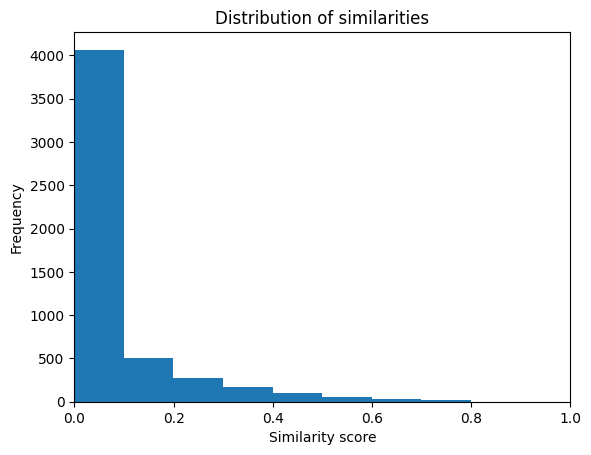

In [6]:
embmodel.to(DEVICE)
embmodel.eval()
query_vec = query_vec.to(DEVICE)

image_paths = list()
image_paths_unix = list()
similarities = list()
all_labels = list()
all_embs = list()


with torch.no_grad():  # disables autograd
    for img, label, path in tqdm(dl, total=len(dl)):  # streams in batches (image, label, file path) triplets
        key_vec = embmodel(img.to(DEVICE)).logits  # converts image to embedding vector
        distance = torch.linalg.norm(query_vec - key_vec, dim=-1)  # computes L2 distance between query and other images (key)
        sim = torch.exp(-distance / (2 * SIGMA ** 2))  # convert distance to similarity score using the RBF kernel

        image_paths.extend(path)
        image_paths_unix.extend(map(lambda x: x.replace("\\", "/"), path))
        similarities.extend(sim.cpu().tolist())
        all_labels.extend(label.tolist())
        all_embs.extend(key_vec.cpu().tolist())

image_paths = np.array(image_paths)
image_paths_unix = np.array(image_paths_unix)
similarities = np.array(similarities)
all_labels = np.array(all_labels)

top_K_idx = np.argsort(similarities)[::-1][:K_RESULTS]

result_img_paths = image_paths[top_K_idx]
result_sim = similarities[top_K_idx]
result_label = all_labels[top_K_idx]
all_embs = np.array(all_embs)

embmodel.cpu()
query_vec = query_vec.cpu()

plt.hist(similarities)
plt.title("Distribution of similarities")
plt.xlabel("Similarity score")
plt.ylabel("Frequency")
plt.xlim(0, 1);

# Preview of Top 10 Results

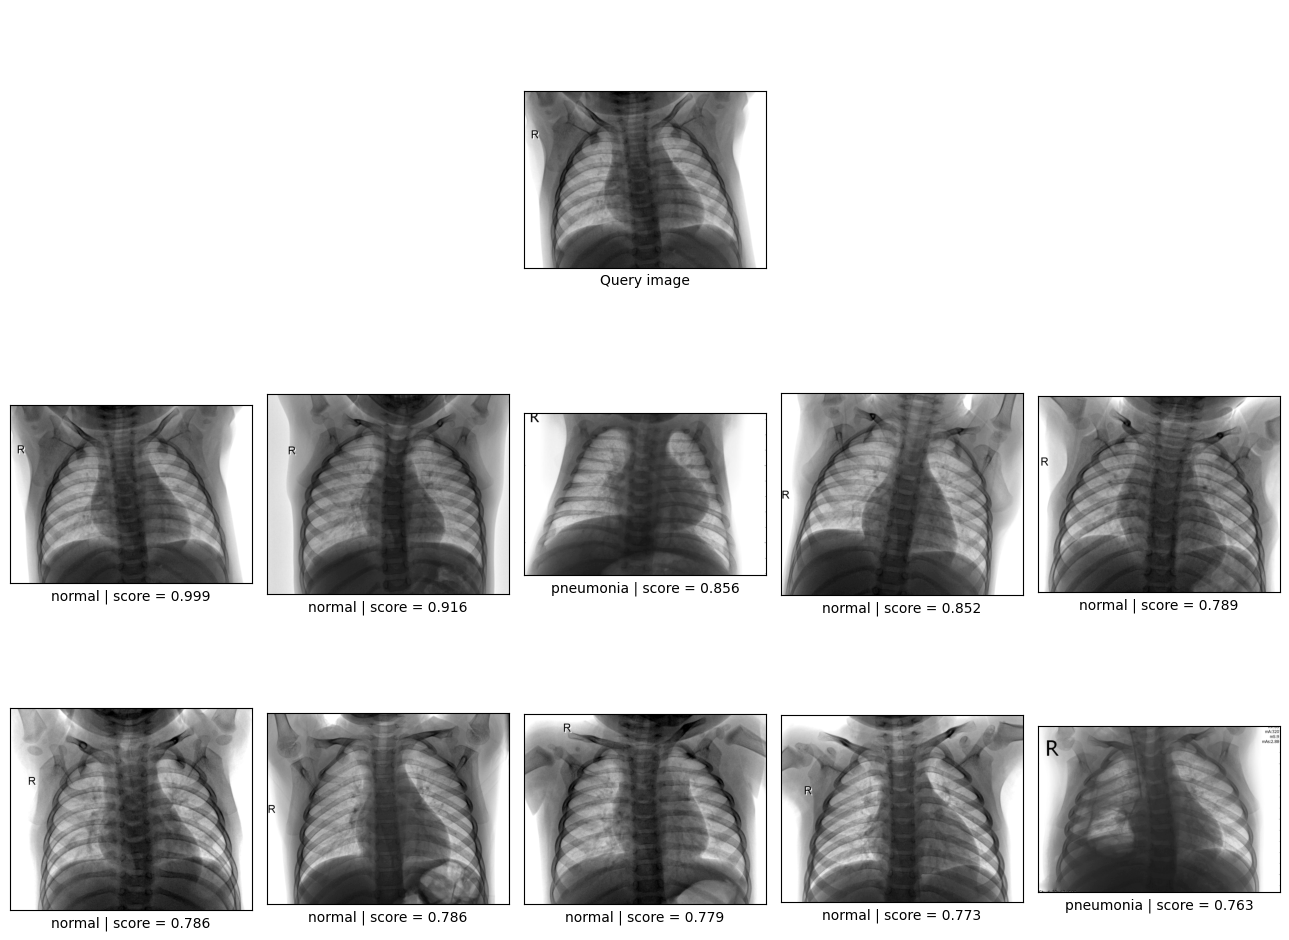

In [8]:
NUM_ROWS = 2
NUM_COLS = 5

assert NUM_ROWS * NUM_COLS == K_RESULTS

_, axs = plt.subplots(NUM_ROWS + 1, NUM_COLS, figsize=(13, 10))

ax = axs[0, NUM_COLS // 2]
ax.imshow(cv2.imread(query_image_path, 0) / 255., "binary")
ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
for i in range(NUM_COLS):
    if i != NUM_COLS // 2:
        axs[0, i].axis("off")
ax.set_xlabel("Query image")

for i, (fp, sim, label) in enumerate(zip(result_img_paths, result_sim, result_label), NUM_COLS):
    img = cv2.imread(fp, 0) / 255.
    diagnosis = "pneumonia" if label == 1 else "normal"

    ax = axs[i // NUM_COLS, i % NUM_COLS]
    ax.imshow(img, "binary")
    ax.set_xlabel(f"{diagnosis} | score = {sim:.3f}")

    ax.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

plt.tight_layout()

# $t$-SNE Embedding Plot

Compression of 64-dimensional vector into a two dimensional Euclidean space

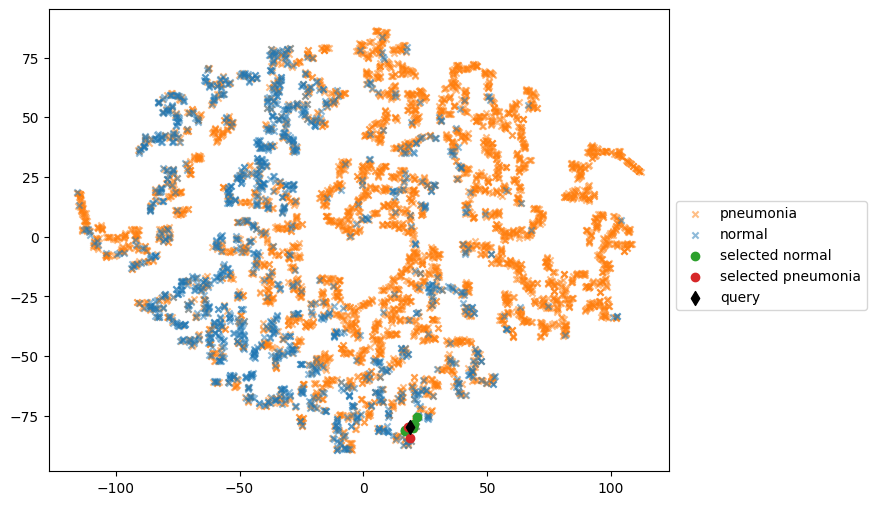

In [9]:
emb_red = TSNE(perplexity=11, random_state=5).fit_transform(np.concatenate([all_embs, query_vec]))
emb_query = emb_red[[-1]]
emb_red = emb_red[:-1]

plt.figure(figsize=(8, 6))

emb_red_distant = np.delete(emb_red, top_K_idx, axis=0)
labels_distant = np.delete(all_labels, top_K_idx)

plt.scatter(*emb_red_distant[labels_distant == 1].T, marker="x", s=20, alpha=0.5, label="pneumonia", c="tab:orange")
plt.scatter(*emb_red_distant[labels_distant == 0].T, marker="x", s=20, alpha=0.5, label="normal", c="tab:blue")
plt.scatter(*emb_red[top_K_idx][all_labels[top_K_idx] == 0].T, c="tab:green", label="selected normal")
plt.scatter(*emb_red[top_K_idx][all_labels[top_K_idx] == 1].T, c="tab:red", label="selected pneumonia")
plt.scatter(*emb_query.T, marker="d", c="k", s=50, label="query")

plt.legend(bbox_to_anchor=(1, 0.6));

# Generating Embedding for Test Set

For each test vector, compute all pairwise distance and similarity to train set 

In [10]:
test_dataset = ImageFolderWithPaths(os.path.join("data", "test"), transform=preprocess_transform)
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

embmodel.to(DEVICE)
embmodel.eval()

similarities_test = list()
all_labels_test = list()
all_embs_test = list()

test_sim_scores = torch.zeros(len(test_dataset), len(dataset))

with torch.no_grad():  # disables autograd
    for img, label, path in tqdm(test_dl, total=len(test_dl)):
        all_embs_test.extend(embmodel(img.to(DEVICE)).logits.cpu().tolist())
        all_labels_test.extend(label.tolist())
        
all_embs_test = np.array(all_embs_test)
all_labels_test = np.array(all_labels_test)

pairwise_dist = cdist(all_embs_test, all_embs)
sim_test = np.exp(-pairwise_dist / (2 * SIGMA ** 2))
selector_idx = np.argsort(pairwise_dist, axis=-1)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\Wei Min\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
100%|██████████| 5/5 [00:30<00:00,  6.12s/it]


# Prediction on Unseen Data

* Normalizing labels by the label frequency
* Computing prediction by taking the labels of the closest 10 results

In [147]:
weighted_labels = np.array(all_labels, dtype=np.float32)
weighted_labels[all_labels == 1] *= 0.7 / all_labels.mean()
pred = (weighted_labels[selector_idx][:, :K_RESULTS].mean(axis=-1) > 0.5).astype(np.float32)

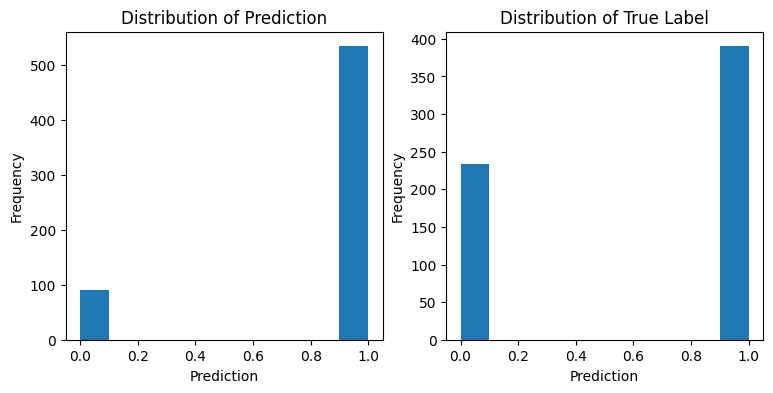

In [148]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plt.hist(pred)
plt.ylabel("Frequency")
plt.xlabel("Prediction")
plt.title("Distribution of Prediction")

plt.subplot(122)
plt.hist(all_labels_test)
plt.ylabel("Frequency")
plt.xlabel("Prediction")
plt.title("Distribution of True Label");

In [149]:
precision, recall, f1, support = precision_recall_fscore_support(all_labels_test, pred, average="binary")

print(f"Accuracy: {np.mean(all_labels_test == pred)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.6362179487179487
Precision: 0.6529080675422139
Recall: 0.8923076923076924
F1-score: 0.7540628385698808
